In [ ]:
# 定義常數與參數
M = 303835  # 總票數
K = 40000   # 獎品數
c = 1650    # 每張 CD 價格（日圓）
d = 13935   # 固定成本（日圓）

In [1]:
import numpy as np

n_vals = np.arange(1, 101)  # n = 1,2,...,100
n_vals = n_vals.astype(float)  
gamma_list = [2, 2.2, 2.4, 2.6, 2.8, 3]

print("γ值  |  E[n] (近似)  |  估計參與者數 N")
print("--------------------------------------")
for gamma in gamma_list:
    weights = n_vals ** (-gamma)
    E_n = np.sum(n_vals * weights) / np.sum(weights)
    N_est = M / E_n
    print(f"{gamma:<4} | {E_n:10.2f} | {N_est:10.0f}")

γ值  |  E[n] (近似)  |  估計參與者數 N
--------------------------------------
2    |       3.17 |      95764
2.2  |       2.42 |     125416
2.4  |       1.96 |     154963
2.6  |       1.67 |     181818
2.8  |       1.48 |     204678
3    |       1.36 |     223373


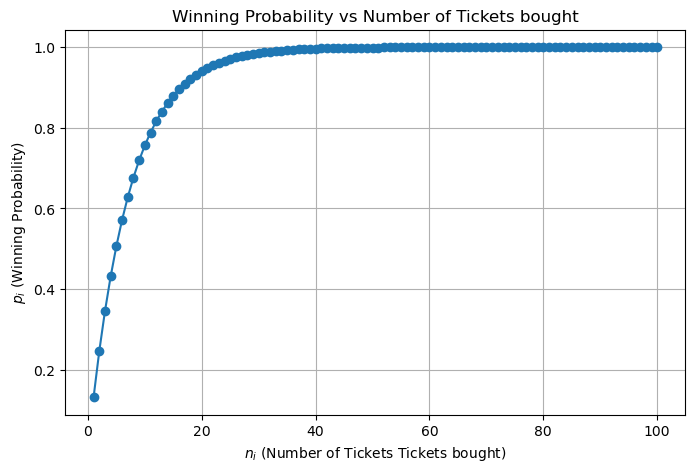

In [2]:
import math
import matplotlib.pyplot as plt

n_range = np.arange(1, 101)

def p_exact(n, M, K):
    # 利用 math.lgamma 計算對數下的組合數比值
    log_binom_Mn = math.lgamma(M - n + 1) - math.lgamma(K + 1) - math.lgamma(M - n - K + 1)
    log_binom_M   = math.lgamma(M + 1)   - math.lgamma(K + 1) - math.lgamma(M - K + 1)
    ratio = math.exp(log_binom_Mn - log_binom_M)
    return 1 - ratio

p_vals = np.array([p_exact(n, M, K) for n in n_range])

plt.figure(figsize=(8,5))
plt.plot(n_range, p_vals, marker='o', linestyle='-')
plt.xlabel('$n_i$ (Number of Tickets Tickets bought)')
plt.ylabel('$p_i$ (Winning Probability)')
plt.title('Winning Probability vs Number of Tickets bought')
plt.grid(True)
plt.savefig('probability.png')
plt.show()

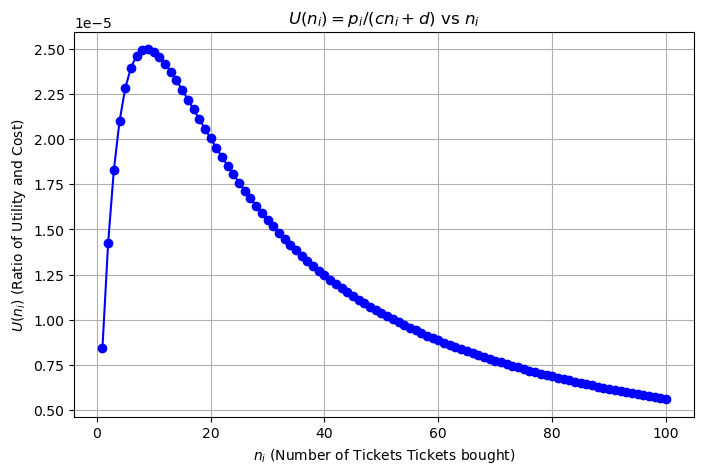

【估計參與者數與最佳投資決策】
γ值  |  估計參與者數 N  |  最佳 n_i*
-----------------------------------
2    |          95764 |   9
2.2  |         125415 |   9
2.4  |         154962 |   9
2.6  |         181818 |   9
2.8  |         204677 |   9
3    |         223373 |   9


In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

gamma_list = [2, 2.2, 2.4, 2.6, 2.8, 3]

# 定義 n 的範圍
n_range = np.arange(1, 101, dtype=float)

# 定義計算中獎機率的函數 (利用對數 Gamma 避免溢位)
def p_exact(n, M, K):
    log_binom_Mn = math.lgamma(M - n + 1) - math.lgamma(K + 1) - math.lgamma(M - n - K + 1)
    log_binom_M   = math.lgamma(M + 1)   - math.lgamma(K + 1) - math.lgamma(M - K + 1)
    ratio = math.exp(log_binom_Mn - log_binom_M)
    return 1 - ratio

# 計算 n_range 下的效用 U(n) (此部分不依賴 γ)
U_vals = np.array([p_exact(n, M, K) / (c * n + d) for n in n_range])
n_opt = n_range[np.argmax(U_vals)]

# 作圖：只繪製一條 U(n) 曲線
plt.figure(figsize=(8,5))
plt.plot(n_range, U_vals, marker='o', linestyle='-', color='blue')
plt.xlabel('$n_i$ (Number of Tickets Tickets bought)')
plt.ylabel('$U(n_i)$ (Ratio of Utility and Cost)')
plt.title('$U(n_i)=p_i/(c n_i+d)$ vs $n_i$')
plt.grid(True)
plt.savefig('utility.png')
plt.show()

# 利用不同 γ 值來估計參與者數 N (透過截斷分布 1～100)
print("【估計參與者數與最佳投資決策】")
print("γ值  |  估計參與者數 N  |  最佳 n_i*")
print("-----------------------------------")
results = []
for gamma in gamma_list:
    # 以截斷分布 1～100 計算平均購買數 E[n]
    weights = n_range ** (-gamma)
    E_n = np.sum(n_range * weights) / np.sum(weights)
    N_est = M / E_n
    results.append((gamma, int(N_est), n_opt))
    print(f"{gamma:<4} | {int(N_est):14d} | {int(n_opt):3d}")

In [4]:
def p_dev(n, n_sym, N_est, K):
    """
    計算若其他玩家均採 n_sym (平均購買 E[n])，則
    當該玩家購買 n 張時的偏離中獎機率。
    這裡我們令其他人總購買數 m_other = (N_est-1)*n_sym，
    總票數為 m_other + n。
    """
    m_other = (N_est - 1) * n_sym
    total = m_other + n
    # 注意：當 total >= K 才有意義（本題 K=40000，且 m_other 很大）
    log_binom_mother = math.lgamma(m_other + 1) - math.lgamma(K + 1) - math.lgamma(m_other - K + 1)
    log_binom_total = math.lgamma(total + 1) - math.lgamma(K + 1) - math.lgamma(total - K + 1)
    ratio = math.exp(log_binom_mother - log_binom_total)
    return 1 - ratio

def best_response(n_sym, N_est, K):
    ns = np.arange(1, 101)
    U_dev_vals = np.array([p_dev(n, n_sym, N_est, K)/(c*n+d) for n in ns])
    return ns[np.argmax(U_dev_vals)]

nash_results = []
for gamma in gamma_list:
    weights = n_range ** (-gamma)
    E_n = np.sum(n_range * weights) / np.sum(weights)
    N_est = M / E_n
    # 初始猜測採用前面效用最大時的 n_opt
    n_sym = results[[g for g in gamma_list].index(gamma)][2]
    for _ in range(100):
        new_n = best_response(n_sym, N_est, K)
        if new_n == n_sym:
            break
        n_sym = new_n
    nash_results.append((gamma, N_est, n_sym))

print("\n【納許均衡（對稱均衡）下的最佳投資決策】")
print("γ值  |  估計參與者數 N  |  納許均衡 n_i*")
print("---------------------------------------")
for gamma, N_est, n_sym in nash_results:
    print(f"{gamma:<4} | {int(N_est):10d}       | {n_sym:3d}")


【納許均衡（對稱均衡）下的最佳投資決策】
γ值  |  估計參與者數 N  |  納許均衡 n_i*
---------------------------------------
2    |      95764       |  34
2.2  |     125415       |  47
2.4  |     154962       |  59
2.6  |     181818       |  71
2.8  |     204677       |  80
3    |     223373       |  88
